In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

import time
from datetime import datetime, timedelta

/project/bios26406/conda/ml4h/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
training_data_imputed_df = pd.read_csv("training_data_imputed_simple_TRAIN.csv.gz") 

In [3]:
training_data_imputed_df.head()
training_data_imputed_df.shape

(90320, 169)

In [4]:
train_df, val_df = train_test_split(training_data_imputed_df, test_size=0.2, random_state=1)

In [5]:
val_df

,ab_class_is_Fluoroquinolone,ab_class_is_Lincosamide,ab_class_is_Nitroimidazole,ab_class_is_Carbapenem,ab_class_is_Aminoglycoside,ab_class_is_Glycopeptide,ab_class_is_Cephalosporin,ab_class_is_Oxazolidinone,ab_class_is_Macrolide,ab_class_is_Lipopeptide,...,count_hematocrit,count_platelets,count_white_blood_cells,age_at_admin,admin_time_since_admission,admission_time_of_day,cdiff_2d_flag,cdiff_7d_flag,cdiff_30d_flag,survival_time
24466,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,6.0,1.0,62.189041,96.0,17.0,0.0,0.0,0.0,9.481944
33121,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,79.339726,0.0,11.0,0.0,0.0,0.0,5.576389
8352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,12.0,1.0,77.205479,480.0,22.0,0.0,0.0,0.0,28.506944
58911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,6.0,1.0,47.356164,0.0,18.0,0.0,0.0,0.0,7.758333
86073,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,55.509589,24.0,23.0,0.0,1.0,1.0,4.541667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7527,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,86.926027,24.0,8.0,0.0,0.0,0.0,5.687500
48785,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,79.038356,0.0,12.0,0.0,0.0,0.0,33.770139
11657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,30.0,1.0,48.813699,408.0,17.0,0.0,0.0,0.0,18.937500
4207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,62.813699,240.0,21.0,0.0,0.0,0.0,13.552083


In [6]:
X = train_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)


## Sensitivity Analysis 
For 30 days 

In [7]:
y_30 = train_df['cdiff_30d_flag']

In [8]:
param_grid = {
    'n_estimators': [50, 70, 100, 150],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.2],
}


neg = (y_30 == 0).sum()
pos = (y_30 == 1).sum()
scale_pos_weight = neg / pos

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=0,
    n_jobs=-1
)

scoring = 'roc_auc'

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    verbose=1,
    n_jobs=-1  
)

In [8]:
neg = (y_30)== 0).sum()
pos = (y_30 == 1).sum()
print(f"Negative: {neg}, Positive: {pos}, Ratio: {neg/pos:.2f}")


Negative: 67822, Positive: 4434, Ratio: 15.30


In [9]:
start_time = time.time()
start_datetime = datetime.now()
print(f"Training started at: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

print("Starting GridSearchCV to find optimal parameters...")
grid_search.fit(X, y_30)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation {scoring} score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

end_time = time.time()
end_datetime = datetime.now()

duration_seconds = end_time - start_time
duration = timedelta(seconds=duration_seconds)

print(f"Training finished at: {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time: {duration}")

Training started at: 2025-05-19 16:24:39
Starting GridSearchCV to find optimal parameters...
Fitting 4 folds for each of 32 candidates, totalling 128 fits

Best parameters found:
{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 150}
Best cross-validation roc_auc score: 0.9092
Training finished at: 2025-05-19 16:32:22
Total training time: 0:07:42.319402


In [45]:
XGB_model_30 = xgb.XGBClassifier(**grid_search.best_params_, 
                                objective='binary:logistic',
                                eval_metric='auc',
                                random_state=0,
                               n_jobs=-1)
XGB_model_30.fit(X, y_30)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [11]:
X_val = val_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_val_30 = val_df['cdiff_30d_flag']

y_val.value_counts()

cdiff_30d_flag
0.0    17027
1.0     1037
Name: count, dtype: int64

In [12]:
y_val_pred_30 = XGB_model_30.predict(X_val)
y_val_prob_30 = XGB_model_30.predict_proba(X_val)[:, 1]  

print("\nClassification Report:")
print(classification_report(y_val_30, y_val_pred_30, target_names=['non-cdiff', 'cdiff']))
print(f"ROC AUC: {roc_auc_score(y_true=y_val_30, y_score=y_val_pred_30):.4}")


Classification Report:
              precision    recall  f1-score   support

   non-cdiff       0.97      1.00      0.99     17027
       cdiff       0.97      0.56      0.71      1037

    accuracy                           0.97     18064
   macro avg       0.97      0.78      0.85     18064
weighted avg       0.97      0.97      0.97     18064

ROC AUC: 0.7815


<Figure size 1200x800 with 0 Axes>

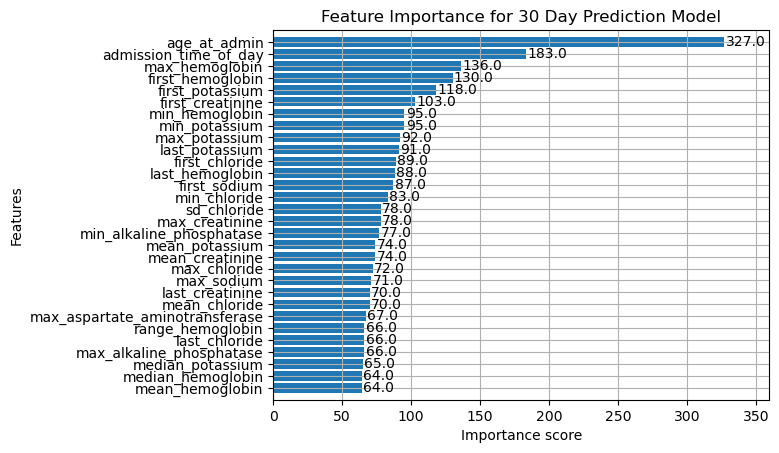

In [50]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(XGB_model_30, max_num_features=30, height=0.8)
plt.title('Feature Importance for 30 Day Prediction Model')
plt.show()

In [ ]:
XGB_model_30.save_model('30d_best_model.json')

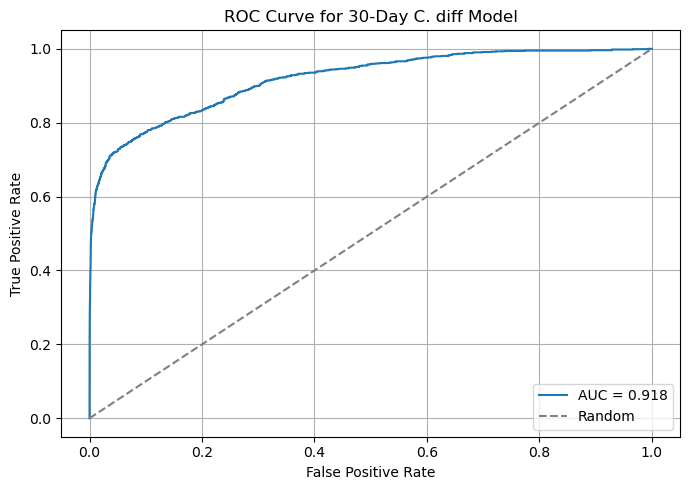

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ground truth (30-day flag)
y_val_30 = val_df["cdiff_30d_flag"]

# Predicted probabilities from your model (positive class only)
y_val_prob_30 = XGB_model_30.predict_proba(X_val)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val_30, y_val_prob_30)
auc_score = roc_auc_score(y_val_30, y_val_prob_30)

# Plot
plt.figure(figsize=(7, 5))
plt.step(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for 30-Day C. diff Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Ground truth labels
y_val_30 = val_df["cdiff_30d_flag"]

# Predicted probabilities (positive class)
y_val_prob_30 = XGB_model_30.predict_proba(X_val)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val_30, y_val_prob_30)

# Compute area under the precision-recall curve (AUPRC)
auprc_score = average_precision_score(y_val_30, y_val_prob_30)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUPRC = {auprc_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [1, 0], linestyle='--', color='gray', label="Random")
plt.title("Precision-Recall Curve for 30-Day C. diff Model")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



For 7 days  

In [8]:
y_7 = train_df['cdiff_7d_flag']

In [12]:
param_grid = {
    'n_estimators': [50, 70, 100, 150],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.2],
}


neg = (y_7 == 0).sum()
pos = (y_7 == 1).sum()
scale_pos_weight = neg / pos

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=0,
    n_jobs=-1
)

scoring = 'roc_auc'

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    verbose=1,
    n_jobs=-1  
)

In [13]:
neg = (y_7 == 0).sum()
pos = (y_7 == 1).sum()
print(f"Negative: {neg}, Positive: {pos}, Ratio: {neg/pos:.2f}")


Negative: 70409, Positive: 1847, Ratio: 38.12


In [18]:
start_time = time.time()
start_datetime = datetime.now()
print(f"Training started at: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

print("Starting GridSearchCV to find optimal parameters...")
grid_search.fit(X, y_7)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation {scoring} score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

end_time = time.time()
end_datetime = datetime.now()

duration_seconds = end_time - start_time
duration = timedelta(seconds=duration_seconds)

print(f"Training finished at: {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time: {duration}")

Training started at: 2025-05-19 17:12:40
Starting GridSearchCV to find optimal parameters...
Fitting 4 folds for each of 32 candidates, totalling 128 fits

Best parameters found:
{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 150}
Best cross-validation roc_auc score: 0.8470
Training finished at: 2025-05-19 17:20:13
Total training time: 0:07:32.969571


In [20]:
XGB_model_7 = xgb.XGBClassifier(**grid_search.best_params_, 
                                objective='binary:logistic',
                                eval_metric='auc',
                                random_state=0,
                               n_jobs=-1)
XGB_model_7.fit(X, y_7)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=-1, num_parallel_tree=None, ...)

In [22]:
X_val = val_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_val_7 = val_df['cdiff_7d_flag']

y_val_7.value_counts()

cdiff_7d_flag
0.0    17626
1.0      438
Name: count, dtype: int64

In [25]:
y_val_pred_7 = XGB_model_7.predict(X_val)
y_val_prob_7 = XGB_model_7.predict_proba(X_val)[:, 1]  

print("\nClassification Report:")
print(classification_report(y_val_7, y_val_pred_7, target_names=['non-cdiff', 'cdiff']))
print(f"ROC AUC: {roc_auc_score(y_true=y_val_7, y_score=y_val_pred_7):.4}")


Classification Report:
              precision    recall  f1-score   support

   non-cdiff       0.99      1.00      0.99     17626
       cdiff       0.91      0.45      0.60       438

    accuracy                           0.99     18064
   macro avg       0.95      0.72      0.80     18064
weighted avg       0.98      0.99      0.98     18064

ROC AUC: 0.7243


In [27]:
XGB_model_7.save_model('7d_best_model.json')

<Figure size 1200x800 with 0 Axes>

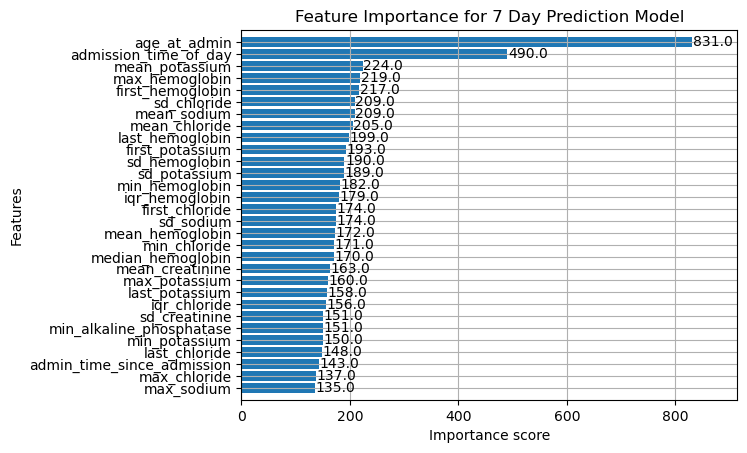

In [51]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(XGB_model_7, max_num_features=30, height=0.8)
plt.title('Feature Importance for 7 Day Prediction Model') 
plt.show()

In [24]:
XGB_model.save_model('7d_best_model.json')

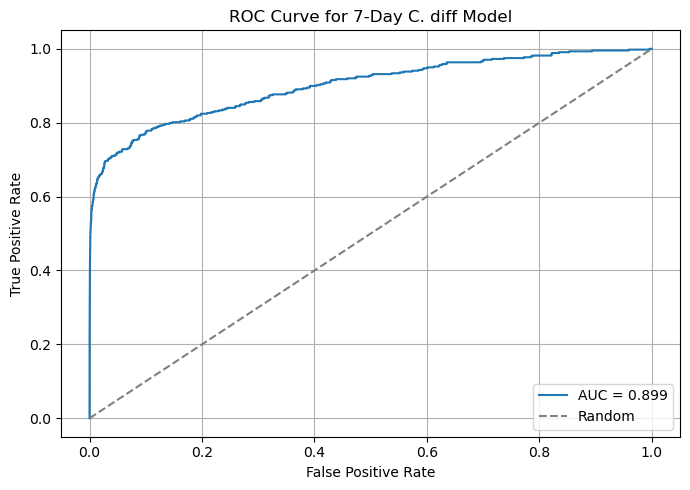

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ground truth (30-day flag)
y_val_7 = val_df["cdiff_7d_flag"]

# Predicted probabilities from your model (positive class only)
y_val_prob_7 = XGB_model_7.predict_proba(X_val)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val_7, y_val_prob_7)
auc_score = roc_auc_score(y_val_7, y_val_prob_7)

# Plot
plt.figure(figsize=(7, 5))
plt.step(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for 7-Day C. diff Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

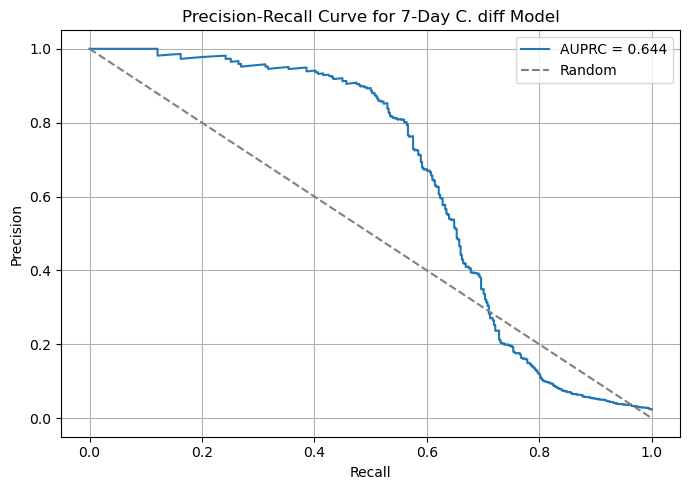

In [58]:
# Ground truth labels
y_val_7 = val_df["cdiff_7d_flag"]

# Predicted probabilities (positive class)
y_val_prob_7 = XGB_model_7.predict_proba(X_val)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val_7, y_val_prob_7)

# Compute area under the precision-recall curve (AUPRC)
auprc_score = average_precision_score(y_val_7, y_val_prob_7)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUPRC = {auprc_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [1, 0], linestyle='--', color='gray', label="Random")
plt.title("Precision-Recall Curve for 7-Day C. diff Model")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


For 2 days  

In [29]:
y_2 = train_df['cdiff_2d_flag']

In [30]:
param_grid = {
    'n_estimators': [50, 70, 100, 150],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.2],
}


neg = (y_2 == 0).sum()
pos = (y_2 == 1).sum()
scale_pos_weight = neg / pos

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=0,
    n_jobs=-1
)

scoring = 'roc_auc'

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    verbose=1,
    n_jobs=-1  
)

In [31]:
neg = (y_2 == 0).sum()
pos = (y_2 == 1).sum()
print(f"Negative: {neg}, Positive: {pos}, Ratio: {neg/pos:.2f}")


Negative: 71992, Positive: 264, Ratio: 272.70


In [32]:
start_time = time.time()
start_datetime = datetime.now()
print(f"Training started at: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

print("Starting GridSearchCV to find optimal parameters...")
grid_search.fit(X, y_2)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation {scoring} score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

end_time = time.time()
end_datetime = datetime.now()

duration_seconds = end_time - start_time
duration = timedelta(seconds=duration_seconds)

print(f"Training finished at: {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time: {duration}")

Training started at: 2025-05-19 17:37:30
Starting GridSearchCV to find optimal parameters...
Fitting 4 folds for each of 32 candidates, totalling 128 fits

Best parameters found:
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Best cross-validation roc_auc score: 0.7959
Training finished at: 2025-05-19 17:44:23
Total training time: 0:06:53.075974


In [33]:
XGB_model_2 = xgb.XGBClassifier(**grid_search.best_params_, 
                                objective='binary:logistic',
                                eval_metric='auc',
                                random_state=0,
                               n_jobs=-1)
XGB_model_2.fit(X, y_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [37]:
X_val = val_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_val_2 = val_df['cdiff_2d_flag']

y_val_2.value_counts()

cdiff_2d_flag
0.0    18002
1.0       62
Name: count, dtype: int64

In [38]:
y_val_pred_2 = XGB_model_2.predict(X_val)
y_val_prob_2 = XGB_model_2.predict_proba(X_val)[:, 1]  

print("\nClassification Report:")
print(classification_report(y_val_2, y_val_pred_2, target_names=['non-cdiff', 'cdiff']))
print(f"ROC AUC: {roc_auc_score(y_true=y_val_2, y_score=y_val_pred_2):.4}")


Classification Report:
              precision    recall  f1-score   support

   non-cdiff       1.00      1.00      1.00     18002
       cdiff       0.82      0.29      0.43        62

    accuracy                           1.00     18064
   macro avg       0.91      0.65      0.71     18064
weighted avg       1.00      1.00      1.00     18064

ROC AUC: 0.6451


<Figure size 1200x800 with 0 Axes>

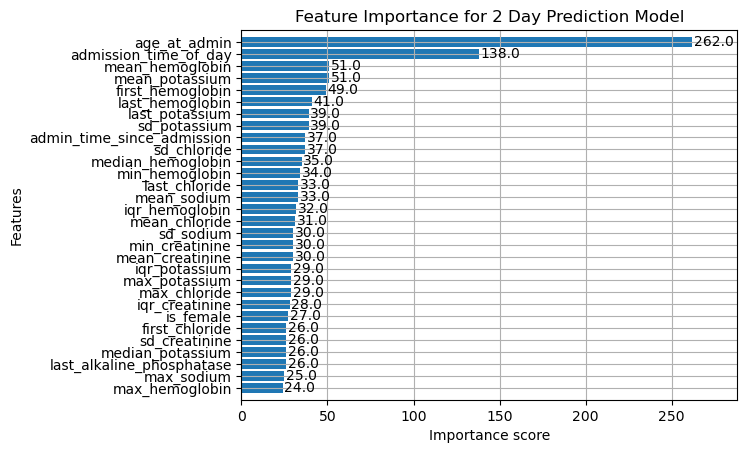

In [52]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(XGB_model_2, max_num_features=30, height=0.8)
plt.title('Feature Importance for 2 Day Prediction Model') 
plt.show()

In [41]:
XGB_model_2.save_model('2d_best_model.json')

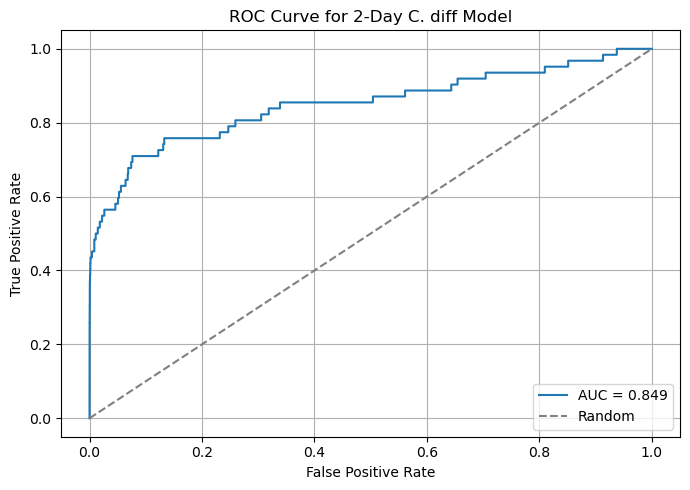

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ground truth (30-day flag)
y_val_2 = val_df["cdiff_2d_flag"]

# Predicted probabilities from your model (positive class only)
y_val_prob_2 = XGB_model_2.predict_proba(X_val)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val_2, y_val_prob_2)
auc_score = roc_auc_score(y_val_2, y_val_prob_2)

# Plot
plt.figure(figsize=(7, 5))
plt.step(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for 2-Day C. diff Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

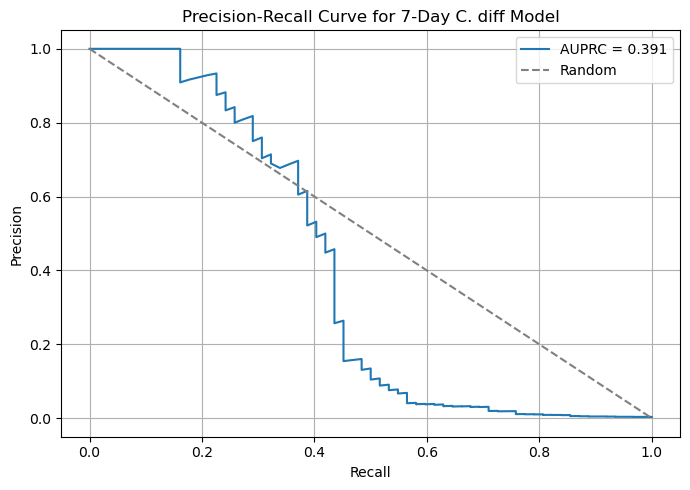

In [60]:
# Ground truth labels
y_val_2 = val_df["cdiff_2d_flag"]

# Predicted probabilities (positive class)
y_val_prob_2 = XGB_model_2.predict_proba(X_val)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val_2, y_val_prob_2)

# Compute area under the precision-recall curve (AUPRC)
auprc_score = average_precision_score(y_val_2, y_val_prob_2)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUPRC = {auprc_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [1, 0], linestyle='--', color='gray', label="Random")
plt.title("Precision-Recall Curve for 7-Day C. diff Model")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()